# CCA

In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-22 14:57:03.684934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 14:57:03.700436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 14:57:03.705228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 14:57:03.719289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 14:57:04.923896: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [2]:
compressed_dv_sims = np.load('../compression_NN/output/sims_compressed_TrF_v1.npy')
compressed_dv_labels = np.load('../compression_NN/output/pars_LFI.npy')

compressed_dv_fid  = np.load('../compression_NN/output/fid_compressed_TrF_v1.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [3]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [4]:
# test
compressed_dv_fid.shape, compressed_dv_labels.shape, compressed_dv_sims.shape

((1, 32), (8187, 2), (8187, 32))

In [5]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=4))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [6]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_1314241/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 78 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_1314241/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 90 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 71 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


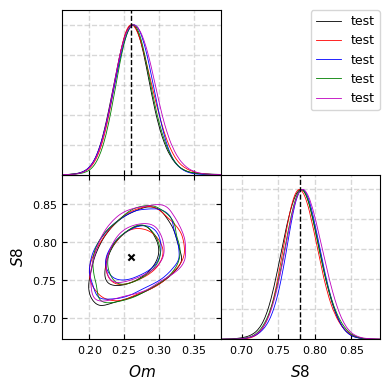

In [7]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [8]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)

In [9]:
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 1577.540473058324
FoM in test 1 is 1576.064312121894
FoM in test 2 is 1681.139717091869
FoM in test 3 is 1619.208425980009
FoM in test 4 is 1453.4217329109838
mean FoM is  1581.4749322326159


# make the NDE smaller (num_transforms=3)

In [10]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=3))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [11]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_1314241/586695301.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 79 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 122 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 89 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 85 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


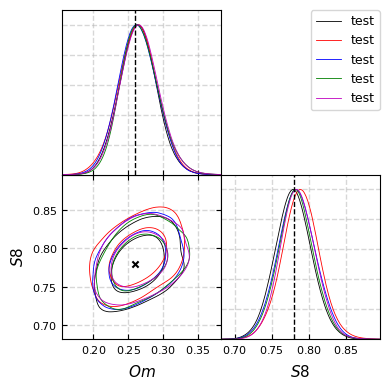

In [12]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [13]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
    
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 1645.9107170333489
FoM in test 1 is 1536.8652584337378
FoM in test 2 is 1533.8876673967413
FoM in test 3 is 1632.7583540792837
FoM in test 4 is 1593.6331615245658
mean FoM is  1588.6110316935356


# Make NDE more complicated

In [14]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=6))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [15]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_1314241/2861931052.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 104 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 97 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


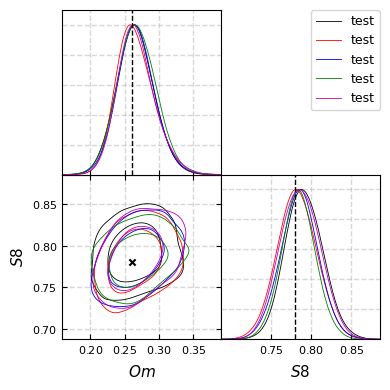

In [16]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [17]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
    
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 1573.1243502173409
FoM in test 1 is 1585.8152882560607
FoM in test 2 is 1694.212466619861
FoM in test 3 is 1733.7529709100106
FoM in test 4 is 1589.4667068414433
mean FoM is  1635.2743565689434
